# Link prediction challenge

In [5]:
# Graph-tool is not available in the standard colab environment so we must first install it...
%%capture
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo
#python3-cairo from Ubuntu's reposity is linked with a different python version; we need to improvise
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall --target=$nb_path pycairo
!pip install --target=$nb_path zstandard

In [6]:
# Install node2vec to create embeddings
%%capture
# update gensim
!pip install -U gensim
!pip install node2vec

In [7]:
# networks
import networkx as nx
import graph_tool.all as gt
from graph_tool import topology, inference, generation, stats, correlations

# machine learning
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, roc_auc_score,plot_roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score

# embeddings
from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import PCA, TruncatedSVD, NMF

# Some math
import scipy.sparse as sp
import numpy as np
from numpy.linalg import inv

# data wrangling
import pandas as pd
from itertools import permutations, combinations, product

# viz
import pylab as plt

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:1500: RuntimeWarning: Error importing Gtk module: cannot import name '_gi' from 'gi' (/usr/lib/python3/dist-packages/gi/__init__.py); GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


## 1. Read network
We are going to use a protein-protein interaction network from S. cervisiae (the yeast that is used to make beer, bread and all sort of yummy things): http://interactome.dfci.harvard.edu/S_cerevisiae/download/YuSci2008.pdf



In [8]:
# Read network
!wget https://github.com/jgarciab/NetworkScience/raw/main/Data/ppi_network_prediction.graphml -O pp.graphml
G = nx.read_graphml("pp.graphml", node_type=int)
g = gt.load_graph('pp.graphml')

num_vertices = g.num_vertices()

# Initialize dataframe with all node pairs (potential links)
df_all_pairs = pd.DataFrame(permutations(G.nodes(), 2))

# Merge with dataframe with actual links to create dummy variable (link / no link)
df_pos = pd.DataFrame(G.edges())
df_pos["link"] = 1
df_all_pairs = pd.merge(df_all_pairs, df_pos, how="outer")
df_all_pairs["link"] = df_all_pairs["link"].fillna(0) #the ones that were not present in df_pos represent absence of links

# Read test dataset
test = pd.read_csv("https://github.com/jgarciab/NetworkScience/raw/main/Data/ppi_network_prediction_test.csv", sep="\t", index_col=0)
test.columns = [0,1,"label"]


--2022-07-20 06:27:16--  https://github.com/jgarciab/NetworkScience/raw/main/Data/ppi_network_prediction.graphml
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jgarciab/NetworkScience/main/Data/ppi_network_prediction.graphml [following]
--2022-07-20 06:27:16--  https://raw.githubusercontent.com/jgarciab/NetworkScience/main/Data/ppi_network_prediction.graphml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117387 (115K) [text/plain]
Saving to: ‘pp.graphml’

pp.graphml          100%[===================>] 114.64K  --.-KB/s    in 0.02s   

2022-07-20 06:27:16 (5.63 MB/s) - ‘pp.graphml’ saved [11738

### How does this network look like?

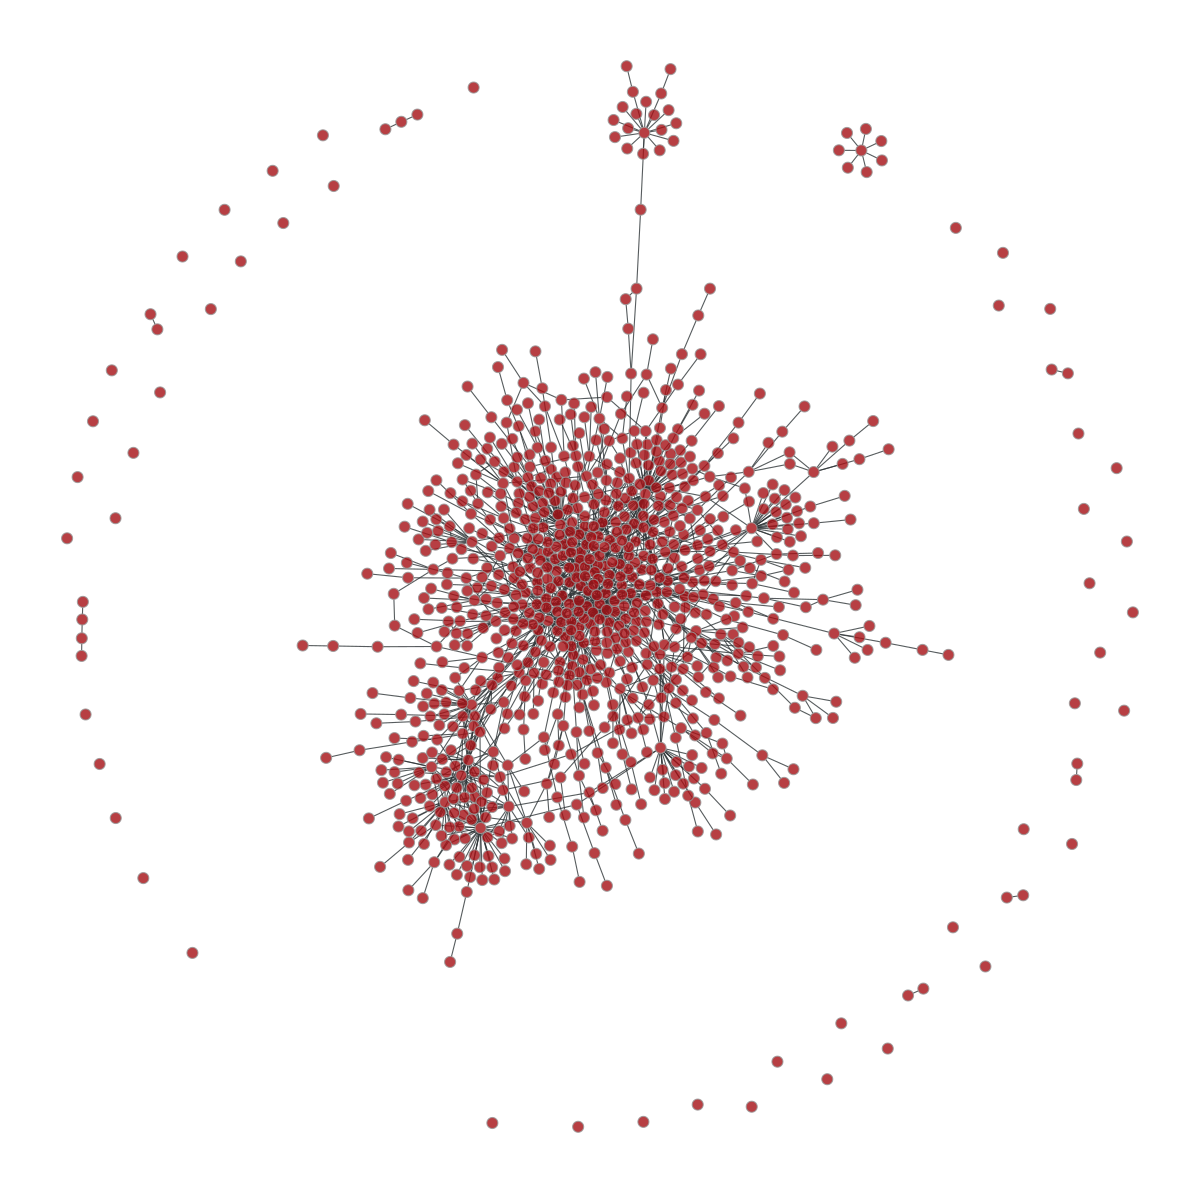

Global clustering:  0.020462906192519927
Degree assortativity:  -0.1704172005377207


<Figure size 720x720 with 0 Axes>

In [9]:
plt.figure(figsize=(10,10))
gt.graph_draw(g)


print("Global clustering: ", nx.transitivity(G))
print("Degree assortativity: ", nx.assortativity.degree_assortativity_coefficient(G))

In [9]:
def create_predictions(df_all_pairs, df_s, test):
  """
  Train a LogisticRegression given the labels from df_all_pairs and the scores from df_s. 
  The model is evaluated in the test dataset

  df_all_pairs: Columns 0,1,label (label = presence of a link in the training data (the graph))
  df_s: Columns 0,1,...
  test: Columns 0,1, link (link = presence of a link in the test data (the actual graph))
  """
  # Use all columns except the first two as independent variables
  col_emb = list(df_s.columns)[2:]

  # Merge the lables to the scores to create a model
  df = pd.merge(df_all_pairs, df_s, how="left", validate="1:1")

  # Create model
  model = LogisticRegressionCV(cv=3, max_iter=1000, class_weight="balanced", n_jobs=-1, scoring="f1")
  model.fit(df[col_emb], df["link"])
  print(model.coef_, model.intercept_)
  # Predict labels
  df["pred"] = model.predict(df[col_emb])
  
  # Merge the predictions with the test dataset to evaluate the prediction
  df_test = pd.merge(test, df)
  
  #recall = ability of the classifier to find all the positive samples.
  #precision = ability of the classifier not to label as positive a sample that is negative.
  print(classification_report(df_test["label"],df_test["pred"]))

  # Plot ROC curve
  plot_roc_curve(model, df_test[col_emb], df_test["label"]) 
  plt.grid(True)

  # return predicted probabilities
  return model.predict_proba(df[col_emb])[:,0]

## 2. Methods based on similarity

The following methods calculate node similarity looking mostly at (variations of) common neighbors.

In graph-tool, this is done with the function s_jaccard = gt.vertex_similarity(g, "jaccard"): https://graph-tool.skewed.de/static/doc/topology.html#graph_tool.topology.vertex_similarity

In [10]:
# create edgelist dataframe (to be able to merge with the networkx data)
edgelist = pd.DataFrame([vi for vi in product(range(g.num_vertices()), repeat=2)])

# map graph-tool labels to graphml node labels
gt_to_graphml_labels = dict((i, int(g.vp['_graphml_vertex_id'][i])) for i in range(g.num_vertices()))
edgelist[0] = edgelist[0].map(gt_to_graphml_labels)
edgelist[1] = edgelist[1].map(gt_to_graphml_labels)


In [11]:
# Calculate jaccard similarity, convert to dataframe (cols 0 and 1 are the node ids)
## calculate jaccard similarity and convert to an array
s_jaccard = gt.vertex_similarity(g, "jaccard")
jaccard = edgelist.copy()
jaccard['score'] = np.array([s_jaccard[i] for i in range(num_vertices)]).reshape(-1)
jaccard['score'] = jaccard['score'].fillna(0) #there are somehow missing values (self-loops, but not only)


## You can change the "jaccard" argument to creat enew one
gt.vertex_similarity?

[[2.70713047]] [-0.0299722]
              precision    recall  f1-score   support

           0       0.52      0.96      0.67       148
           1       0.74      0.11      0.20       148

    accuracy                           0.54       296
   macro avg       0.63      0.54      0.44       296
weighted avg       0.63      0.54      0.44       296



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


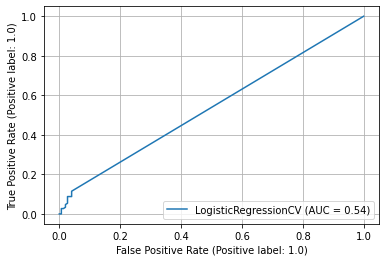

In [12]:
# create predictions
prob_jac = create_predictions(df_all_pairs, jaccard, test)
# save the probabilities for later (stacking algorithms)
df_all_pairs["jaccard"] = prob_jac

### You can try some methods from here as well
https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html

For example maybe nodes link proportionally to their degree

In [39]:
# Calculate pref attachment
pa = nx.preferential_attachment(G, permutations(G.nodes(), 2))
df_pa = pd.DataFrame(list(pa))
df_pa.head()

,0,1,2
0,0,1,666
1,0,2,814
2,0,439,74
3,0,8,444
4,0,9,296


[[0.05630451]] [-0.98060371]
              precision    recall  f1-score   support

           0       0.60      0.86      0.71       148
           1       0.76      0.43      0.55       148

    accuracy                           0.65       296
   macro avg       0.68      0.65      0.63       296
weighted avg       0.68      0.65      0.63       296



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


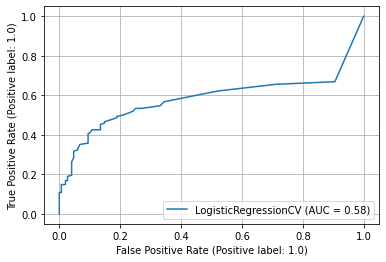

In [40]:
# create predictions
prob_jac = create_predictions(df_all_pairs, df_pa, test)
# save the probabilities for later (stacking algorithms)
df_all_pairs["pa"] = prob_jac

## 3. Methods based on paths
There are also methods that look not only at immediate neighbors, but also at longer-paths. You can do this using matrix multiplication (remember that A^2 represents the number of paths between i and j in two steps)


One of this methods is Katz similarity.

In [13]:
## Katz index (https://stackoverflow.com/questions/62069781/how-to-find-the-similarity-between-pair-of-vertices-using-katz-index-in-python)

#Calculate largest eigenvector
L = L = gt.laplacian(g, norm=True)
e = np.linalg.eigvals(L.A)
print("Largest eigenvalue:", max(e))
beta = 1/max(e)
I = np.identity(num_vertices) #create identity matrix

#Katz score
ks = inv(I - gt.adjacency(g)*beta) - I
ks = np.array(ks.real)

Largest eigenvalue: (2.000000000000016+0j)


In [14]:
# Put it into a nice format
df_katz = edgelist.copy()
df_katz["katz"] = ks.reshape(-1)

[[-0.21861468]] [-0.03336082]
              precision    recall  f1-score   support

           0       0.50      0.84      0.63       148
           1       0.52      0.17      0.26       148

    accuracy                           0.51       296
   macro avg       0.51      0.51      0.44       296
weighted avg       0.51      0.51      0.44       296



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


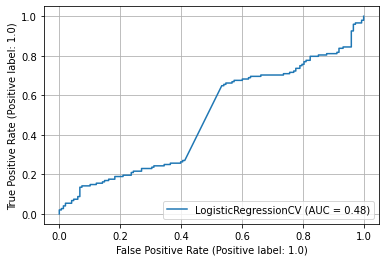

In [15]:
# create predictions
prob_jac = create_predictions(df_all_pairs, df_katz, test)
# save the probabilities for later (stacking algorithms)
df_all_pairs["katz"] = prob_jac

# 4. Methods based on SBM
A SBM encodes the probability of two nodes in communities i and j linking to each other (with some corrections, e.g. hierarchies and degree-corrections). We can use those probabilities for link prediciton.

In [16]:
#state = gt.minimize_nested_blockmodel_dl(g)

#It takes too long to run (1+ hours) so I run it for you (this is not exactly how it should be done)
#for an example on how to do it see here: https://graph-tool.skewed.de/static/doc/demos/inference/inference.html#edge-prediction-as-binary-classification
#probs = [state.get_edges_prob([i], entropy_args=dict(partition_dl=False)) for i in list(product(range(g.num_vertices()), repeat=2))]
probs = pd.read_csv("https://github.com/jgarciab/NetworkScience/raw/main/Data/ppi_sbm_probs.txt", header=None).values
len(probs)

929296

[[0.42249721]] [3.56583915]
              precision    recall  f1-score   support

           0       0.67      0.30      0.41       148
           1       0.55      0.85      0.67       148

    accuracy                           0.57       296
   macro avg       0.61      0.57      0.54       296
weighted avg       0.61      0.57      0.54       296



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


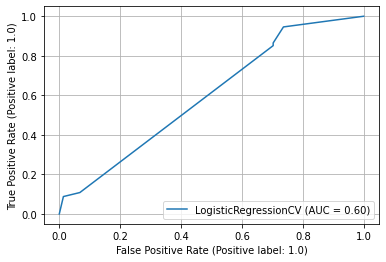

In [17]:
# # Put it into a nice format
df_sbm = edgelist.copy()
df_sbm["sbm"] = probs

# create predictions
prob_jac = create_predictions(df_all_pairs, df_sbm, test)
# save the probabilities for later (stacking algorithms)
df_all_pairs["sbm"] = prob_jac

## 5. Methods based on node embeddings (spectral methods and matrix factorization; node2vec)
The following methods will create node embeddings based on transformations of the adjacency matrix, and on random walks

In order to predict a link, each pair of embeddings needs to be combined (e.g. by computing the L1 norm (np.abs(v1-v2))


* 5.1 shows an example of a spectral method (you can try different methods: TruncatedSVD, PCA, SpectralEmbedding and NMF; you can modify the dimension of the embedding as well)
* 5.2 shows an example of node2vec (you can change the p and q parameters, the length of walks, etc)




In [18]:
def calculate_dist(v1, v2):
  """
  Calculate the L1 distance
  """
  return np.abs(v1 - v2)

def create_pair_distance(embeddings, G):
  """
  Calculates the distance between embeddings using calculate_dist
  """
  # Create dictionary with embeddings
  df_clsvd = pd.DataFrame(embeddings)
  df_clsvd.index = G.nodes()
  df_clsvd = {k: row.values for k,row in df_clsvd.iterrows()}


  # Calculate all distances and convert to dictionary
  pairs = combinations(G.nodes(), 2)
  all_pairs = [calculate_dist(df_clsvd[n1], df_clsvd[n2]) for n1,n2 in pairs]

  # Concatenate labels with node pairs      
  all_pairs = pd.DataFrame(all_pairs)
  all_pairs =  pd.concat([pd.DataFrame(combinations(G.nodes(), 2)), all_pairs.reset_index(drop=True)], axis=1)
  all_pairs.columns = [0,1]+[f"_{i}" for i in range(2, len(all_pairs.columns))]

  # Add the reverse of the node pair
  all_pairs = pd.concat([all_pairs, all_pairs.rename(columns={0:1, 1:0})])
  
  return all_pairs

### 5.1 Example with SVD
Try also PCA, SpectralEmbedding and NMF 

Try different time of embeddings sizes (n_components)

In [19]:
A = nx.to_scipy_sparse_matrix(G)
clusters_svd = TruncatedSVD(n_components=10)
clusters_svd.fit(A)
cl_svd = clusters_svd.components_.T

# clusters_svd = SpectralEmbedding(affinity = 'precomputed', n_components=5)
# clusters_svd.fit(A)
# cl_svd = clusters_svd.embedding_

In [20]:
df_emb = create_pair_distance(cl_svd, G)

[[-36.28328884  34.26897916 -53.2443673   48.44942599  29.14500109
  -38.2030028   18.06738602 -19.05638867 -14.70890125  12.6913854 ]] [-0.52206639]
              precision    recall  f1-score   support

           0       0.54      0.89      0.67       148
           1       0.69      0.24      0.36       148

    accuracy                           0.57       296
   macro avg       0.62      0.57      0.52       296
weighted avg       0.62      0.57      0.52       296



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


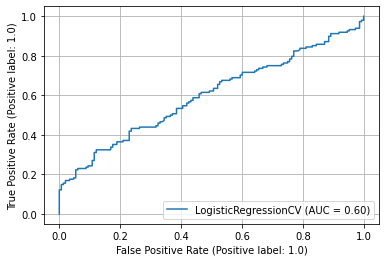

In [21]:
probs = create_predictions(df_all_pairs, df_emb, test)
# save the probabilities for later (stacking algorithms)
df_all_pairs["svd"] = probs

## 5.2 Example with node2vec

You can create and save more predictions by changing the q and p parameters

In [4]:
# Generate walks
from node2vec import Node2Vec
dimensions = 32
workers = 8
node2vec = Node2Vec(G, dimensions=32, q=0.5, walk_length=30, num_walks=10, workers=8)  


# Embed nodes (dimensions = embedding size)
model = node2vec.fit(window=5, min_count=1, batch_words=4) 
#model = gensim.models.Word2Vec(vector_size = dimensions, workers=8, window=5, min_count=1, batch_words=4)

#vocab = model.wv.index2word
# Embeddings as a pandas dataframe
node2vec = pd.DataFrame([model.wv.get_vector(str(_)) for _ in G.nodes()])


Computing transition probabilities:   0%|          | 0/964 [00:00<?, ?it/s]

In [22]:
# Create all distances
df_emb = create_pair_distance(node2vec, G)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[[-0.83225408 -0.6535014  -0.97416743 -1.39524821 -0.98730006 -1.61758811
  -1.0838009  -0.89281779 -1.02745361 -1.2272077  -0.43580854 -0.93986632
  -1.17233603 -1.10995608 -0.97769812 -0.99228212 -0.93882219 -0.66714545
  -0.04253248 -1.44931967 -1.37994548 -1.14858662 -1.13605278 -1.10056559
  -0.79590351 -0.88724755 -0.53310068 -1.09963519 -0.99116285 -1.14964823
  -0.44949794 -0.70041447]] [11.71743061]
              precision    recall  f1-score   support

           0       0.54      0.96      0.69       148
           1       0.81      0.17      0.28       148

    accuracy                           0.56       296
   macro avg       0.67      0.56      0.48       296
weighted avg       0.67      0.56      0.48       296



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


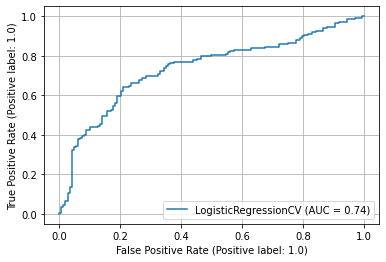

In [23]:
# Caulate predictions
probs = create_predictions(df_all_pairs, df_emb, test)
# save the probabilities for later (stacking algorithms)
df_all_pairs["node2vec"] = probs

# 6. Stacking classifiers
For each method we fitted a logisticregression, which returned a probability of two nodes being connected. 

We can now fit a meta-classifier, which takes those predictions and combines them in order to (hopefully) create a better classifier.

You can try different algorithms apart from LogisticRegressionCV: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning


In [41]:
# Merge measures with labels
df_test_stack = pd.merge(df_all_pairs, test, how="right")
df_test_stack.head()


,0,1,link,jaccard,katz,sbm,svd,node2vec,pa,label
0,213,214,0.0,0.507492,0.508339,0.415454,0.556214,0.943492,0.727228,1
1,2,470,0.0,0.507492,0.508339,0.415454,0.784493,0.944646,0.727228,1
2,81,233,0.0,0.507492,0.543861,0.415454,0.112142,0.838446,0.113062,1
3,138,0,0.0,0.507492,0.502438,0.415454,0.961769,0.469220,0.000000,1
4,510,94,0.0,0.507492,0.508339,0.415454,0.531688,0.692729,0.727228,1


In [42]:
# Columns to use in the prediction
col_pred = ["jaccard","katz","svd","node2vec","sbm","pa"]

[('jaccard', 16.080000047732558), ('katz', -3.9025388583673224), ('svd', -3.48960686383733), ('node2vec', -22.928492176202184), ('sbm', 16.92423346883417), ('pa', -15.48960963496193)] [2.41982852]
              precision    recall  f1-score   support

           0       0.53      0.99      0.69       148
           1       0.91      0.14      0.24       148

    accuracy                           0.56       296
   macro avg       0.72      0.56      0.46       296
weighted avg       0.72      0.56      0.46       296



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


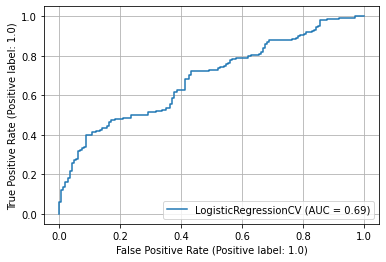

In [43]:
# Create model
model = LogisticRegressionCV(cv=3, max_iter=1000, class_weight="balanced", n_jobs=-1, scoring="f1")
model.fit(df_all_pairs[col_pred], df_all_pairs["link"])
# Print coefficients
print(list(zip(col_pred, model.coef_[0])), model.intercept_)


# Create predictions and evaluate model
df_test_stack["pred"] = model.predict(df_test_stack[col_pred])


#recall = ability of the classifier to find all the positive samples.
#precision = ability of the classifier not to label as positive a sample that is negative.
print(classification_report(df_test_stack["label"],df_test_stack["pred"]))

plot_roc_curve(model, df_test_stack[col_pred], df_test_stack["label"]) 
plt.grid(True)


In [ ]:
#Link prediction is hard!

# 7. Explore some of the node pairs with the highest probability of a link
You can look at our results and explore which proteins may be interacting 

e.g. using the test dataset (you can also find the ones with the highest probability of being a link in the full dataset)

In [44]:
df_test_stack.loc[(df_test_stack["link"]==0) & (df_test_stack["label"]!=1) & (df_test_stack["pred"]==1 ) ]

,0,1,link,jaccard,katz,sbm,svd,node2vec,pa,label,pred
182,856,97,0.0,0.507492,0.505667,0.415454,0.557029,0.110572,0.704328,0,1.0
235,159,94,0.0,0.494223,0.498538,0.415454,0.526591,0.411523,0.000678,0,1.0


In [46]:
#
d = nx.get_node_attributes(G, "label")
d[856], d[97]

#https://www.yeastgenome.org/locus/YGL172W
#YGL172W: FG-nucleoporin component of central core of the nuclear pore complex; contributes directly to nucleocytoplasmic transport and maintenance of the nuclear pore complex (NPC) permeability barrier; found in stable complex with Nic96p and two other FG-nucleoproteins (Nsp1p and Nup57p) 2 
#YJL061W: Linker nucleoporin component of the nuclear pore complex (NPC); also part of the NPC cytoplasmic filaments; contributes to nucleocytoplasmic transport and NPC biogenesis; forms stable associations with three FG-nucleoporins (Nsp1p, Nup159p, and Nup116p); relocalizes to the cytosol in response to hypoxia




('YGL172W', 'YJL061W')

# z. Example of Graph Neural Networks (graphSAGE )

Sometimes we have metadata and can use it to improve our classification
Tutorial: https://docs.dgl.ai/tutorials/blitz/4_link_predict.html#sphx-glr-tutorials-blitz-4-link-predict-py

(note: there are also options to use GNNs without metadata)

In [ ]:
!pip install dgl-cu113 -f https://data.dgl.ai/wheels/repo.html
!pip install torch==1.12.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 235.1 MB 38 kB/s 
     |████████████████████████████████| 281 kB 14.1 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user


In [ ]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
import pandas as pd
import networkx as nx

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]
g

Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={})

In [ ]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]


In [ ]:
train_g = dgl.remove_edges(g, eids[:test_size])

In [ ]:
from dgl.nn import SAGEConv

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


In [ ]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())



In [ ]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']


In [46]:
model = GraphSAGE(g.ndata['feat'].shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)


In [ ]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))




# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))


# Thumbnail credits: Link Prediction with Neo4j, Mark Needham
# sphinx_gallery_thumbnail_path = '_static/blitz_4_link_predict.png'

In [ ]:
#embeddings
h.shape

## This is how we created the network

In [ ]:
if 0:
  # Create network for challenge
  df = pd.read_csv("http://interactome.dfci.harvard.edu/S_cerevisiae/download/CCSB-Y2H.txt",sep="\t",header=None)
  df = pd.concat([df, df.rename(columns={0:1, 1:0})])

  G = nx.from_pandas_edgelist(df, source=0, target=1)
  G.remove_edges_from(nx.selfloop_edges(G))
  Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
  G0 = G.subgraph(Gcc[0])

  df = pd.DataFrame(G0.edges())
  df = pd.concat([df, df.rename(columns={0:1, 1:0})]).drop_duplicates()

  nodes = df[0].unique()
  d_conv = dict(zip(nodes, range(len(nodes))))
  df[0] = df[0].map(d_conv)
  df[1] = df[1].map(d_conv)

  G = nx.from_pandas_edgelist(df, source=0, target=1)

  adj = nx.to_scipy_sparse_array(G, nodelist=range(len(G)))


  u,v = np.nonzero(adj)
  eids = np.arange(len(u))
  eids = np.random.permutation(eids)
  test_size = int(len(eids) * 0.1)
  train_size = len(u) - test_size
  test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
  train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

  # Find all negative edges and split them for training and testing
  adj_neg =  adj.todense() + np.eye(len(G)) - 1
  neg_u, neg_v = np.nonzero(adj_neg)

  neg_eids = np.random.choice(len(neg_u), len(u))
  test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
  train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]
  # Positive and negative examples to test (50-50)
  pos = pd.DataFrame(np.array([test_pos_u,test_pos_v]).T)
  pos["label"] = 1
  neg = pd.DataFrame(np.array([test_neg_u,test_neg_v]).T)
  neg["label"] = 0
  df = pd.concat([pos,neg])
  df.to_csv("../Data/ppi_network_prediction_test.csv", sep="\t")
            
  # Network with 10% removed
  G.remove_edges_from(zip(test_pos_u, test_pos_v))
  nx.set_node_attributes(G, {v:k for k,v in d_conv.items()}, name="label")
  nx.write_graphml(G, "../Data/ppi_network_prediction.graphml")


x=  pd.merge(pd.DataFrame(G.edges()),df, how="outer", indicator=True)
x["_merge"].value_counts()